In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import io
import os
import datetime
from bs4 import BeautifulSoup
import requests as rq
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow import keras

2023-04-30 21:36:26.250547: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import opendatasets as od
import pandas

In [3]:
#download data set
df = pandas.read_excel('selected_songs.xlsx')
df.head(10)

,genre,lyrics,Artist,Song
0,prog,"I am just a new boy,\nStranger in this town.,\...",Pink Floyd,Young Lust Lyrics
1,prog,"Eins, zwei, drei, alle!,Ooooh You cannot reach...",Pink Floyd,Waiting For The Worms Lyrics
2,prog,"All alone, or in twos,\nThe ones who really lo...",Pink Floyd,Outside The Wall Lyrics
3,prog,"Into the distance a ribbon of black,\nStretche...",Pink Floyd,Learning To Fly Lyrics
4,prog,"You got to be crazy, gotta have a real need,\n...",Pink Floyd,Dogs Lyrics
5,prog,"Long ago and far away in a different age,\nwhe...",King Crimson,Dinosaur Lyrics
6,prog,"A tiny flame inside my hand,\nA compromise I n...",Porcupine Tree,Mellotron Scratch Lyrics
7,prog,"I can't see your face,\nAnd I can't breathe yo...",Opeth,Famine Lyrics
8,prog,I can't see the meaning of this life I'm leadi...,Opeth,In My Time of Need Lyrics
9,prog,"Out on the road there are fireflies circling,\...",Opeth,Death Whispered a Lullaby Lyrics


In [4]:
#split into two data frames- 1 per genre
rock_songs_og = df[df['genre'] == 'prog']
pop_songs_og = df[df["genre"] == 'pop']
pop_songs_og.head(10)

,genre,lyrics,Artist,Song
413,pop,"All the leaves are brown and the sky is gray.,...",Sia,California Dreamin' Lyrics
414,pop,"You terrify me, cuz you're a man, you're not a...",Sia,Fair Game Lyrics
415,pop,Naku penda piya-naku taka piya mpenziwe (I lov...,Michael Jackson,Liberian Girl Lyrics
416,pop,"In the news today, from the strange and weird ...",Michael Jackson,Tabloid Junkie Lyrics
417,pop,"I've seen the world,\nDone it all, had my cake...",Lana Del Rey,Young And Beautiful Lyrics
418,pop,"RedOne,\nKonvict,\nGaga (oh-oh, eh),I've had a...",Lady GaGa,Just Dance Lyrics
419,pop,"Hold me,\nlike the river Jordan,,\nand I will ...",Michael Jackson,Will You Be There Lyrics
420,pop,"What you do to me is indescribable,,\nGot me s...",Lana Del Rey,Queen Of Disaster Lyrics
421,pop,"People can take everything away from you,\nBut...",Britney Spears,My Prerogative Lyrics
422,pop,"I told ya,\nI told ya,\nI told ya,\nBaby,\nBab...",Rihanna,Rockstar 101 Lyrics


In [5]:
#preprocess data to add new line characters at the end of each song so it splits properly (rock)
temp_string = ""+'\n'
rock_songs = rock_songs_og
for i in range(0, len(rock_songs['lyrics'])):
    song = rock_songs['lyrics'][i]+temp_string
    rock_songs['lyrics'][i] = song


/var/folders/83/5wnj97dd2mj8v_nh18h2tx7r0000gn/T/ipykernel_18673/2747817086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rock_songs['lyrics'][i] = song


In [6]:
#preprocess data to add new line characters at the end of each song so it splits properly (pop)
pop_songs = pop_songs_og
pop_songs.reset_index(inplace=True)
temp_string = ""+'\n'
for i in range(0, len(pop_songs['lyrics'])):
    song = pop_songs['lyrics'][i]
    pop_songs['lyrics'][i] = song

/var/folders/83/5wnj97dd2mj8v_nh18h2tx7r0000gn/T/ipykernel_18673/41078601.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_songs['lyrics'][i] = song


In [7]:
pop_songs_og.head(5)

,index,genre,lyrics,Artist,Song
0,413,pop,"All the leaves are brown and the sky is gray.,...",Sia,California Dreamin' Lyrics
1,414,pop,"You terrify me, cuz you're a man, you're not a...",Sia,Fair Game Lyrics
2,415,pop,Naku penda piya-naku taka piya mpenziwe (I lov...,Michael Jackson,Liberian Girl Lyrics
3,416,pop,"In the news today, from the strange and weird ...",Michael Jackson,Tabloid Junkie Lyrics
4,417,pop,"I've seen the world,\nDone it all, had my cake...",Lana Del Rey,Young And Beautiful Lyrics


In [8]:
def lyrics_corpus(df): #function to split lyrics into lines
    #df['genre'] = text[column].str.replace('[{}]'.format(string.punctuation), '')
    lowered_lyrics = df['lyrics'].str.lower()
    lowered_lyrics = df['lyrics'].str.cat() #what does this do
    corpus = lowered_lyrics.split('\n')
    for item in range(len(corpus)):
        corpus[item] = corpus[item].rstrip()
    corpus = [item for item in corpus if item != '']
    return corpus

In [9]:
rock_lines = lyrics_corpus(rock_songs)
pop_lines = lyrics_corpus(pop_songs)

In [10]:
def tokenize_corpus(corpus): #tokenizer maps each word in input doc to unique integer from most to least frequent
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    return tokenizer

In [11]:
tokenized_rock = tokenize_corpus(rock_lines)
#print(tokenized_rock.word_index)
tokenized_pop = tokenize_corpus(pop_lines)
#print(tokenized_pop.word_index)

In [12]:
#translating lines of songs to their corresponding integers; 2D array of integers representing words
tokenized_rock_sequences = tokenized_rock.texts_to_sequences(rock_lines)
tokenized_pop_sequences = tokenized_rock.texts_to_sequences(pop_lines)
    #print(tokenized_rock_sequences)

In [13]:
#setting number vals
    # print(len(tokenized_rock_sequences[32]))
    # print(rock_lines[32])
    # print(max_line_length_pop)
num_words = max(len(tokenized_rock.word_index) + 1, len(tokenized_pop.word_index)+1) #max between the two tokenizers
print(num_words)
max_line_length = 20  ##setting the max line length for the model after testing above

6718


In [14]:
#all sequences have same length by adding zeros to create inputs of the same shape
padded_rock = pad_sequences(tokenized_rock_sequences, maxlen=max_line_length, padding='pre')
padded_pop = pad_sequences(tokenized_pop_sequences, maxlen = max_line_length, padding = 'pre')

In [15]:
#splitting the data into input and output (rock)
x_rock, y_rock = padded_rock[:,:-1], padded_rock[:,-1]


print(x_rock[0])
print(y_rock[0])
print(padded_rock[0])
print(len(x_rock[0]))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   6 101  51   5
 141]
593
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   6 101  51   5
 141 593]
19


In [60]:
#splitting the data into input and output (pop)
x_pop, y_pop = padded_pop[:,:-1], padded_pop[:,-1]


print(x_pop[0])
print(y_pop[0])
print(padded_pop[0])
print(len(x_pop[0]))

[   0    0    0    0    0    0    0    0    0    0   12    1  577   24
 2278    4    1  130   13]
6664
[   0    0    0    0    0    0    0    0    0    0   12    1  577   24
 2278    4    1  130   13 6664]
19


In [16]:
#splitting the data into test and train (rock)
x_train_rock = x_rock[0:int(0.9*len(x_rock))]
x_test_rock = x_rock[int(0.9*len(x_rock)):len(x_rock)]
y_train_rock = y_rock[0:int(0.9*len(y_rock))]
y_test_rock = y_rock[int(0.9*len(y_rock)):len(y_rock)]
print(x_train_rock.shape)
print(x_test_rock.shape)
print(y_train_rock.shape)
print(y_test_rock.shape)
validation_data_rock = [x_test_rock, y_test_rock] #PUT IN MODEL.FIT

(8995, 19)
(1000, 19)
(8995,)
(1000,)


In [61]:
#splitting the data into test and train (pop)
x_train_pop = x_pop[0:int(0.9*len(x_pop))]
x_test_pop = x_pop[int(0.9*len(x_pop)):len(x_pop)]
y_train_pop = y_pop[0:int(0.9*len(y_pop))]
y_test_pop = y_pop[int(0.9*len(y_pop)):len(y_pop)]
print(x_train_pop.shape)
print(x_test_pop.shape)
print(y_train_pop.shape)
print(y_test_pop.shape)
validation_data_pop = [x_test_pop, y_test_pop] #PUT IN MODEL.FIT

(17555, 19)
(1951, 19)
(17555,)
(1951,)


In [62]:
print(x_test_rock[2])
print(x_test_pop[2])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0 6439    7    1]
[   0    0    0    0    0    0    0    0    0    0  162   75   10 1608
  561   96   10 1110    1]


In [67]:
#making the model!
model_bidirectional = Sequential()
model_bidirectional.add(Embedding(num_words, 128, input_length = max_line_length-1)) #PLAY AROUND WITH OUTPUT DIM OF 128 (64?32?)
model_bidirectional.add(Bidirectional(LSTM(64))) #equivalent to training 2 LSTMS
# model.add(Bidirectional(LSTM(64))) #equivalent to training 2 LSTMS
#ADD A STACKED LSTM LATER TO REDUCE OVERFITTING AND INCREASE GENERALIZATION? no, see above
#ADD A DROPOUT LAYER TO REDUCE OVERFITTING?
model_bidirectional.add(Dropout(0.5)) 
model_bidirectional.add(Dense(24, activation='softmax')) 
model_bidirectional.add(Dense(12, activation='softmax'))
model_bidirectional.add(Dense(num_words, activation='softmax')) #WHAT SHOULD BE THE FINAL SHAPE- WORKS WHEN IT IS ONE BUT THE RNN BUILT IN CLASS AND THE ONE ON GITHUB FOR LYRICS USE THE NUMBER OF AVAILABLE CHARS/WORDS


In [68]:
#compiling the model
model_bidirectional.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [71]:
model_standard = Sequential()
model_standard.add(Embedding(num_words, 128, input_length = max_line_length-1)) #PLAY AROUND WITH OUTPUT DIM OF 128 (64?32?)
model_standard.add((LSTM(64))) #equivalent to training 2 LSTMS
# model.add(Bidirectional(LSTM(64))) #equivalent to training 2 LSTMS
#ADD A STACKED LSTM LATER TO REDUCE OVERFITTING AND INCREASE GENERALIZATION? no, see above
#ADD A DROPOUT LAYER TO REDUCE OVERFITTING?
model_standard.add(Dropout(0.5)) 
model_standard.add(Dense(24, activation='softmax')) 
model_standard.add(Dense(12, activation='softmax'))
model_standard.add(Dense(num_words, activation='softmax')) 

In [72]:
model_standard.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [24]:
def sample(preds, temperature=1.0):
    """Helper function to sample an index from a probability array."""
    preds = np.asarray(preds).astype('float64')
    preds = np.exp(np.log(preds) / temperature)  # softmax
    preds = preds / np.sum(preds)                #
    probas = np.random.multinomial(1, preds, 1)  # sample index
    return np.argmax(probas)                     #

In [96]:
array_of_seeds = ["I love", "I want to", "I think you", "To be or not to be", "Its Brittany", "Off the lean, the syrup, the fluid, I'mma tell you sum told me to do it, Put a perc in ya hand and ya blew it, Hit the room and you know we get to it", "Right now, he's probably slow dancin'With a bleached-blond tramp and she's probably gettin' frisky, Right now, he's probably buyin' her some fruity little drink, 'Cause she can't shoot whiskey, Right now, he's probably up behind her with a pool-stick, Showin' her how to shoot a combo, And he don't know"]

In [97]:
def generate_with_temperature(genre_lines, tokenized_genre, model_genre):
    #start_index = random.randint(0, len(genre_lines) - max_line_length - 1)
    for seed in array_of_seeds:
        for temperature in [0.2, 0.5, 1.0]:
                print('----- temperature:', temperature)

                generated = ''
#                 print(genre_lines[start_index])
                print(seed)
#                 sentence = genre_lines[start_index]
                sentence = seed
                generated += sentence
                print('----- Generating with seed: "' + sentence + '"')
                sys.stdout.write(generated)

                for i in range(5):
                    token_list = tokenized_genre.texts_to_sequences([sentence])[0]
                    token_list = pad_sequences([token_list], maxlen=max_line_length-1, padding='pre')
                    predicted = model_genre.predict(token_list)[0]
                    print("predicted: ", predicted)
                    next_index = sample(predicted, temperature)
                    next_word = tokenized_genre.sequences_to_texts([[next_index]])
                    next_word_string = ''.join(next_word)
                    print(next_word_string)

                    sentence = sentence[1:] + " "
                    sentence = sentence + next_word_string

                    sys.stdout.write(sentence)
                    sys.stdout.flush()
                print()

In [64]:
start_index = random.randint(0, len(rock_lines) - max_line_length - 1)
sentence = rock_lines[start_index]

token_list = tokenized_rock.texts_to_sequences([sentence])[0]
token_list = pad_sequences([token_list], maxlen=max_line_length-1, padding='pre')
predicted = model.predict(token_list)[0]
next_token = np.argmax(predicted)
print(tokenized_rock.sequences_to_texts([[next_token]]))

token_list = token_list[:, 1:]
print(token_list)
next_input = np.append(token_list, next_token)
print(next_input)

next_input.reshape(1,19)
predicted = model.predict(next_input.reshape(1,19))[0]
next_token = np.argmax(predicted)
print(tokenized_rock.sequences_to_texts([[next_token]]))

1/1 [==============================] - 0s 24ms/step
['me']


In [33]:
def generate_text_no_temp(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenized_rock.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list)
        #print(predicted)
        output_word = ""
        for word,index in tokenized_rock.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [99]:
#train with fit
history_rock_bi = model_bidirectional.fit(
    x_train_rock, 
    y_train_rock, 
    batch_size = 64, 
    epochs = 25, 
    #callbacks=[print_callback],
    validation_data = validation_data_rock
)

Epoch 1/25
141/141 [==============================] - 6s 39ms/step - loss: 6.7536 - accuracy: 0.0248 - val_loss: 8.6576 - val_accuracy: 0.0310
Epoch 2/25
141/141 [==============================] - 6s 39ms/step - loss: 6.5324 - accuracy: 0.0282 - val_loss: 8.6914 - val_accuracy: 0.0300
Epoch 3/25
141/141 [==============================] - 6s 40ms/step - loss: 6.4677 - accuracy: 0.0321 - val_loss: 8.7042 - val_accuracy: 0.0280
Epoch 4/25
141/141 [==============================] - 6s 40ms/step - loss: 6.4247 - accuracy: 0.0345 - val_loss: 8.6814 - val_accuracy: 0.0250
Epoch 5/25
141/141 [==============================] - 6s 40ms/step - loss: 6.3885 - accuracy: 0.0352 - val_loss: 8.6689 - val_accuracy: 0.0250
Epoch 6/25
141/141 [==============================] - 6s 41ms/step - loss: 6.3654 - accuracy: 0.0370 - val_loss: 8.7047 - val_accuracy: 0.0260
Epoch 7/25
141/141 [==============================] - 6s 39ms/step - loss: 6.3432 - accuracy: 0.0375 - val_loss: 8.7335 - val_accuracy: 0.0220

In [75]:
history_rock_standard = model_standard.fit(
    x_train_rock, 
    y_train_rock, 
    batch_size = 64, 
    epochs = 25, 
    #callbacks=[print_callback],
    validation_data = validation_data_rock
)

Epoch 1/50
71/71 [==============================] - 7s 58ms/step - loss: 8.7640 - accuracy: 0.0176 - val_loss: 8.7235 - val_accuracy: 0.0310
Epoch 2/50
71/71 [==============================] - 4s 54ms/step - loss: 8.6360 - accuracy: 0.0231 - val_loss: 8.6361 - val_accuracy: 0.0310
Epoch 3/50
71/71 [==============================] - 4s 52ms/step - loss: 8.5138 - accuracy: 0.0231 - val_loss: 8.5504 - val_accuracy: 0.0310
Epoch 4/50
71/71 [==============================] - 3s 48ms/step - loss: 8.3914 - accuracy: 0.0216 - val_loss: 8.4666 - val_accuracy: 0.0310
Epoch 5/50
71/71 [==============================] - 3s 45ms/step - loss: 8.2716 - accuracy: 0.0231 - val_loss: 8.3883 - val_accuracy: 0.0310
Epoch 6/50
71/71 [==============================] - 3s 46ms/step - loss: 8.1592 - accuracy: 0.0231 - val_loss: 8.3169 - val_accuracy: 0.0310
Epoch 7/50
71/71 [==============================] - 3s 45ms/step - loss: 8.0563 - accuracy: 0.0231 - val_loss: 8.2541 - val_accuracy: 0.0310
Epoch 8/50
71

In [91]:
history_pop_bidirectional = model_bidirectional.fit(
    x_train_pop, 
    y_train_pop, 
    batch_size = 64, 
    epochs = 25, 
    #callbacks=[print_callback],
    validation_data = validation_data_pop
)

Epoch 1/25
275/275 [==============================] - 11s 41ms/step - loss: 6.2594 - accuracy: 0.0447 - val_loss: 6.8388 - val_accuracy: 0.0492
Epoch 2/25
275/275 [==============================] - 12s 44ms/step - loss: 6.0821 - accuracy: 0.0477 - val_loss: 6.8391 - val_accuracy: 0.0492
Epoch 3/25
275/275 [==============================] - 12s 44ms/step - loss: 6.0210 - accuracy: 0.0477 - val_loss: 6.8359 - val_accuracy: 0.0492
Epoch 4/25
275/275 [==============================] - 12s 42ms/step - loss: 5.9779 - accuracy: 0.0477 - val_loss: 6.8569 - val_accuracy: 0.0492
Epoch 5/25
275/275 [==============================] - 11s 40ms/step - loss: 5.9468 - accuracy: 0.0477 - val_loss: 6.8602 - val_accuracy: 0.0492
Epoch 6/25
275/275 [==============================] - 12s 42ms/step - loss: 5.9182 - accuracy: 0.0489 - val_loss: 6.8685 - val_accuracy: 0.0502
Epoch 7/25
275/275 [==============================] - 11s 40ms/step - loss: 5.8948 - accuracy: 0.0541 - val_loss: 6.8646 - val_accuracy:

In [63]:
history_pop_standard = model_standard.fit(
    x_train_pop, 
    y_train_pop, 
    batch_size = 128, 
    epochs = 100, 
    #callbacks=[print_callback],
    validation_data = validation_data_pop
)

Epoch 1/100
138/138 [==============================] - 8s 57ms/step - loss: 7.6212 - accuracy: 0.0477 - val_loss: 7.5075 - val_accuracy: 0.0492
Epoch 2/100
138/138 [==============================] - 8s 57ms/step - loss: 7.4459 - accuracy: 0.0477 - val_loss: 7.4148 - val_accuracy: 0.0492
Epoch 3/100
138/138 [==============================] - 8s 57ms/step - loss: 7.3104 - accuracy: 0.0477 - val_loss: 7.3091 - val_accuracy: 0.0492
Epoch 4/100
138/138 [==============================] - 8s 57ms/step - loss: 7.0609 - accuracy: 0.0477 - val_loss: 7.0123 - val_accuracy: 0.0492
Epoch 5/100
138/138 [==============================] - 8s 57ms/step - loss: 6.6902 - accuracy: 0.0477 - val_loss: 6.8345 - val_accuracy: 0.0492
Epoch 6/100
138/138 [==============================] - 8s 60ms/step - loss: 6.5141 - accuracy: 0.0477 - val_loss: 6.7769 - val_accuracy: 0.0492
Epoch 7/100
138/138 [==============================] - 8s 58ms/step - loss: 6.4263 - accuracy: 0.0477 - val_loss: 6.7495 - val_accuracy:

138/138 [==============================] - 8s 57ms/step - loss: 6.0498 - accuracy: 0.0477 - val_loss: 6.8819 - val_accuracy: 0.0492
Epoch 58/100
138/138 [==============================] - 8s 59ms/step - loss: 6.0493 - accuracy: 0.0477 - val_loss: 6.8862 - val_accuracy: 0.0492
Epoch 59/100
138/138 [==============================] - 8s 58ms/step - loss: 6.0489 - accuracy: 0.0477 - val_loss: 6.8914 - val_accuracy: 0.0492
Epoch 60/100
138/138 [==============================] - 8s 58ms/step - loss: 6.0485 - accuracy: 0.0477 - val_loss: 6.8956 - val_accuracy: 0.0492
Epoch 61/100
138/138 [==============================] - 8s 58ms/step - loss: 6.0481 - accuracy: 0.0477 - val_loss: 6.8998 - val_accuracy: 0.0492
Epoch 62/100
138/138 [==============================] - 8s 58ms/step - loss: 6.0478 - accuracy: 0.0477 - val_loss: 6.9044 - val_accuracy: 0.0492
Epoch 63/100
138/138 [==============================] - 8s 57ms/step - loss: 6.0475 - accuracy: 0.0477 - val_loss: 6.9088 - val_accuracy: 0.049

In [100]:
#generate randomly with temperature modification for each genre 
print("generating with temperature: Rock")
generate_with_temperature(rock_lines, tokenized_rock, model_bidirectional) #TODO: need to define the two different models
# print("generating with temperature: Pop")
# generate_with_temperature(pop_lines, tokenized_pop, model_bidirectional)


generating with temperature: Rock
----- temperature: 0.2
I love
----- Generating with seed: "I love"
1/1 [==============================] - 0s 25ms/step
predicted:  [4.9184778e-06 2.9079805e-03 8.9786155e-03 ... 1.6756514e-09 1.6274522e-09
 1.6092589e-09]
you
1/1 [==============================] - 0s 24ms/step
predicted:  [5.5917273e-05 2.7466640e-03 4.2256243e-03 ... 2.6309968e-08 2.5917986e-08
 2.5823688e-08]
here
1/1 [==============================] - 0s 29ms/step
predicted:  [5.4820348e-06 3.0082092e-03 9.0941032e-03 ... 1.8727602e-09 1.8196582e-09
 1.7997007e-09]
me
1/1 [==============================] - 0s 29ms/step
predicted:  [4.9683285e-06 2.9173749e-03 8.9899795e-03 ... 1.6924024e-09 1.6437841e-09
 1.6254424e-09]
me
1/1 [==============================] - 0s 27ms/step
predicted:  [6.0442620e-05 2.4675597e-03 3.6201561e-03 ... 3.0117583e-08 2.9698452e-08
 2.9609115e-08]
day
e you here me me day
----- temperature: 0.5
I love
----- Generating with seed: "I love"
1/1 [============

1/1 [==============================] - 0s 25ms/step
predicted:  [8.5831685e-05 1.4111254e-03 1.6181580e-03 ... 4.9570861e-08 4.9128182e-08
 4.9118626e-08]
time
1/1 [==============================] - 0s 24ms/step
predicted:  [1.0444345e-04 7.6722912e-04 7.1611418e-04 ... 6.7913021e-08 6.7590214e-08
 6.7740437e-08]
time
1/1 [==============================] - 0s 26ms/step
predicted:  [1.7851407e-03 3.2562548e-05 1.5399231e-05 ... 1.9155188e-08 1.9242487e-08
 1.9318058e-08]
light
1/1 [==============================] - 0s 27ms/step
predicted:  [1.89199054e-03 2.22385370e-05 1.00596535e-05 ... 1.51121888e-08
 1.51898671e-08 1.52513273e-08]
light
1/1 [==============================] - 0s 26ms/step
predicted:  [4.5873261e-05 3.0407552e-03 5.1114340e-03 ... 2.1498488e-08 2.1140695e-08
 2.1045988e-08]
day
 or not to be time time light light day
----- temperature: 0.5
To be or not to be
----- Generating with seed: "To be or not to be"
1/1 [==============================] - 0s 32ms/step
predicted:

1/1 [==============================] - 0s 25ms/stepm told me to do it, Put a perc in ya hand and ya blew it, Hit the room and you know we get to it me me
predicted:  [3.0539493e-05 3.5457325e-03 7.0225075e-03 ... 1.3063078e-08 1.2802598e-08
 1.2722488e-08]
go
1/1 [==============================] - 0s 27ms/step told me to do it, Put a perc in ya hand and ya blew it, Hit the room and you know we get to it me me 
predicted:  [5.0748940e-06 2.9372829e-03 9.0134256e-03 ... 1.7250679e-09 1.6756485e-09
 1.6570050e-09]
out
1/1 [==============================] - 0s 27ms/steptold me to do it, Put a perc in ya hand and ya blew it, Hit the room and you know we get to it me me go o
predicted:  [4.8197966e-04 1.3792663e-03 1.0830802e-03 ... 4.7655114e-08 4.7505914e-08
 4.7486168e-08]
round
he lean, the syrup, the fluid, I'mma tell you sum told me to do it, Put a perc in ya hand and ya blew it, Hit the room and you know we get to it me me go out round
----- temperature: 1.0
Off the lean, the syrup, t

1/1 [==============================] - 0s 22ms/stepond tramp and she's probably gettin' frisky, Right now, he's probably buyin' her some fruity little drink, 'Cause she can't shoot whiskey, Right now, he's probably up behind her with a pool-stick, Showin' her how to shoot a combo, And he don't know you stay you you
predicted:  [4.9086007e-06 2.9061062e-03 8.9763300e-03 ... 1.6723389e-09 1.6242226e-09
 1.6060625e-09]
me
 now, he's probably slow dancin'With a bleached-blond tramp and she's probably gettin' frisky, Right now, he's probably buyin' her some fruity little drink, 'Cause she can't shoot whiskey, Right now, he's probably up behind her with a pool-stick, Showin' her how to shoot a combo, And he don't know you stay you you me
----- temperature: 1.0
Right now, he's probably slow dancin'With a bleached-blond tramp and she's probably gettin' frisky, Right now, he's probably buyin' her some fruity little drink, 'Cause she can't shoot whiskey, Right now, he's probably up behind her wi

In [55]:
generate_text_no_temp("i love", 5, model, max_line_length)

1/1 [==============================] - 0s 24ms/step
[9.8296197e-04 6.4010499e-04 1.2364762e-03 ... 2.2495989e-05 2.2755892e-05
 2.3008984e-05]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

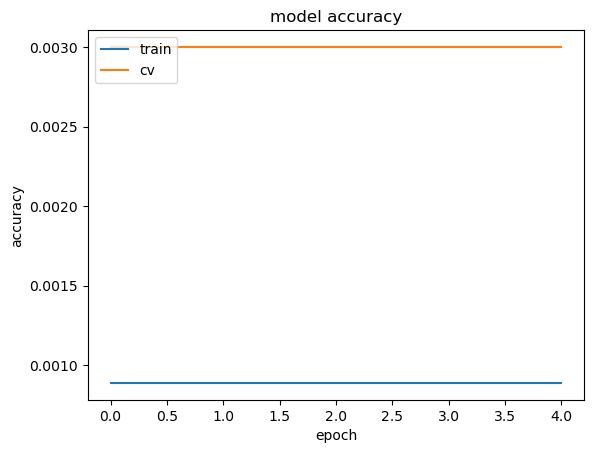

In [265]:
import matplotlib.pyplot as plt
#model accuracy
plt.plot(history_rock.history['accuracy'])
plt.plot(history_rock.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left') #cv is cross validation
plt.show()

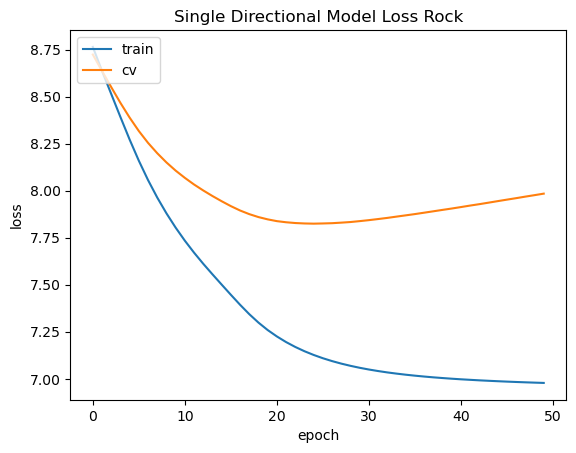

In [76]:
#model loss
plt.plot(history_rock_standard.history['loss'])
plt.plot(history_rock_standard.history['val_loss'])
plt.title('Single Directional Model Loss Rock')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left')
plt.show()

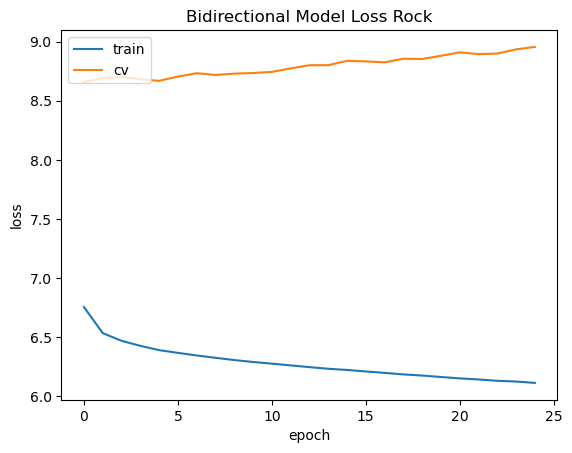

In [102]:
#model loss
plt.plot(history_rock_bi.history['loss'])
plt.plot(history_rock_bi.history['val_loss'])
plt.title('Bidirectional Model Loss Rock')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left')
plt.show()

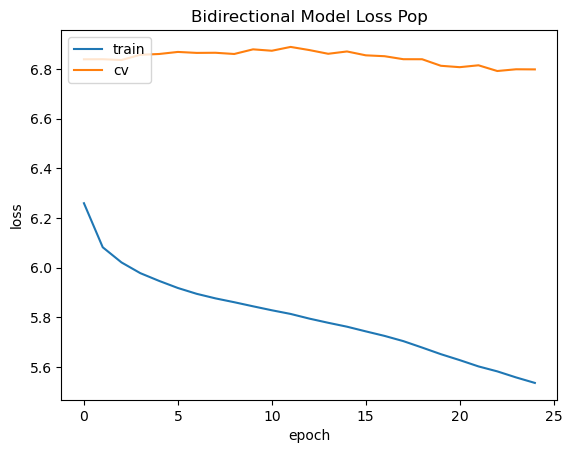

In [101]:
#model loss pop
plt.plot(history_pop_bidirectional.history['loss'])
plt.plot(history_pop_bidirectional.history['val_loss'])
plt.title('Bidirectional Model Loss Pop')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left')
plt.show()

In [ ]:
#generate with loop to add generated words to end of sequence to use as next input 